# Hands-on 9: Noisy QAOA

In this notebook, you will 

    - implement a noisy version of the QAOA algorithm and will compare it to the noiseless case.

    - learn how to specify imperfections of your hardware model

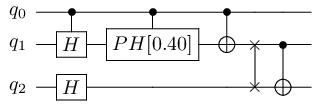

In [1]:
from qat.lang.AQASM import Program, H, PH, SWAP, CNOT
prog = Program()
reg = prog.qalloc(3)
prog.apply(H, reg[2])
prog.apply(H.ctrl(), reg[0:2])
prog.apply(PH(0.4).ctrl(), reg[0:2])
prog.apply(CNOT, reg[0:2])
prog.apply(SWAP, reg[1:3])
prog.apply(CNOT, reg[1:3])
circ = prog.to_circ()

%qatdisplay circ

In [2]:
from qat.linalg import LinAlg

qpu = LinAlg()
result = qpu.submit(circ.to_job())
for sample in result:
    print("State %s, probability %s, err %s"%(sample.state, sample.probability, sample.err))


State |000>, probability 0.4999999999999999, err None
State |011>, probability 0.4999999999999999, err None


A noisy quantum processor is characterized by 

- a **hardware model**: this object describes the quantum gates (their duration, the *quantum channel* that defines them, ...) and the environment (also described by quantum channels)
- a **simulation method**: the user can choose between a deterministic and a stochastic method to compute the final result.
    - The deterministic method is based on a density-matrix representation of the system and is hence limited to small numbers of qubits. 
    - The stochastic method is based a statevector representation, and can thus be used for larger numbers of qubits. It may necessitate a large number of samples to converge to a reliable result 

In [3]:
from qat.hardware import DefaultHardwareModel
from qat.qpus import NoisyQProc
from qat.quops import ParametricAmplitudeDamping, ParametricPureDephasing

# Here, we instantiate the DefaultHardware with gate times and a description of environmental noise
#We choose to model environmental noise with two simple kinds of noise: **amplitude damping** and **pure dephasing noise** 
#with their respective characteristic decay times, $T_1$ and $T_\varphi$ (in the Lindblad approximation). 

hardware_model = DefaultHardwareModel(
                    gate_times = {"H": 2, "PH": lambda angle : 5*angle, "CNOT": 30, "SWAP": 40,
                                  "C-H": 40, "C-PH": lambda angle : 40},
                    idle_noise = [ParametricAmplitudeDamping(T_1=1000), ParametricPureDephasing(T_phi=100)]
                )


import qat.noisy, qat.linalg
# We define a first noisy quantum processor with this hardware model, 
# and a deterministic method to simulate the computation of the circuit
noisy_qpu = NoisyQProc(hardware_model = hardware_model, sim_method = "deterministic")

result = noisy_qpu.submit(circ.to_job())
for sample in result:
    print("State %s, probability %s, err %s"%(sample.state, sample.probability, sample.err))

State |000>, probability 0.5511862017847824, err None
State |011>, probability 0.4488137982152173, err None


In [4]:
noisy_qpu = NoisyQProc(hardware_model = hardware_model, sim_method = "stochastic",
                       backend_simulator=qat.linalg.LinAlg(),n_samples=100)

result = noisy_qpu.submit(circ.to_job())
for sample in result.raw_data:
    print("State %s, probability %s, err %s"%(sample.state, sample.probability, sample.err))

State |000>, probability 0.534339943265357, err 0.014486532607001718
State |011>, probability 0.4743367256823443, err 0.013176506452957997


### Exercise 1:

Play with T_1 and T_phi times, which quantify the quality/lifetime of qubits, and see how the result differs from the noiseless case

In [5]:
hardware_model = DefaultHardwareModel(
                    gate_times = {"H": 2, "PH": lambda angle : 5*angle, "CNOT": 30, "SWAP": 40,
                                  "C-H": 40, "C-PH": lambda angle : 40},
                    idle_noise = [ParametricAmplitudeDamping(T_1=100), ParametricPureDephasing(T_phi=200)]
                )


noisy_qpu = NoisyQProc(hardware_model = hardware_model, sim_method = "deterministic")
result = noisy_qpu.submit(circ.to_job())
for sample in result.raw_data:
    print("State %s, probability %s, err %s"%(sample.state, sample.probability, sample.err))

State |000>, probability 0.8302022371775302, err None
State |011>, probability 0.16979776282246947, err None


 We will now focus on the effect of noise on variational algorithms. For which values of T1 and T_phi the outputs correspond to the noiseless case?


Number of gates:  89


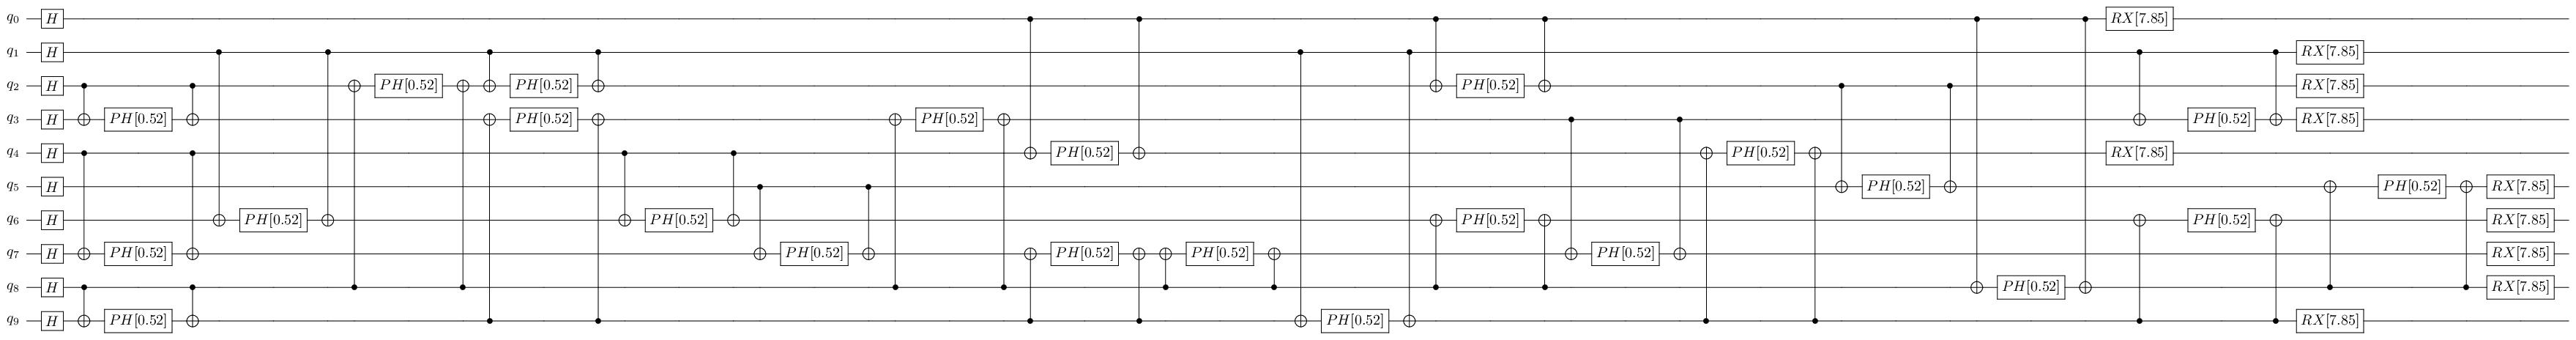

In [6]:
import networkx as nx
import numpy as np
from qat.vsolve.qaoa import MaxCut

# we get the simplest QAOA Ansatz from previous exercise

n_qubits = 10
problem_graph = nx.generators.random_graphs.erdos_renyi_graph(n_qubits, 0.5, seed=10)
problem = MaxCut(problem_graph)

# we bind the variables to arbitrary values so that we can compare the effects of noise
ansatz = problem.qaoa_ansatz(1).circuit
binded_ansatz = ansatz.bind_variables({"\\gamma_{0}": np.pi/3,"\\beta_{0}": 5*np.pi/2 })

print("Number of gates: ", len(ansatz.ops))
%qatdisplay binded_ansatz

Once the parametrized circuit binded use it to obtain the wavefunction:

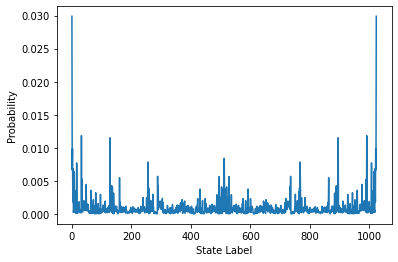

In [7]:
#Noiseless case
import matplotlib.pyplot as plt
from qat.core.simutil import wavefunction


wf = wavefunction(binded_ansatz, qpu, probs=True)
plt.xlabel("State Label")
plt.ylabel("Probability")
plt.plot(wf);

You can modify the T_1 and T_phi in the following cell to next see the impact of those. You could for example start with a low 1e0 time and increase it to get where the noise does not seem to have an impact anymore.

In [8]:
hardware_model_NISQ = DefaultHardwareModel(
                    gate_times = {"H": 2, "PH": 5, "RX": 5, "CNOT": 30, "SWAP": 40
                                  },
                    idle_noise = [ParametricAmplitudeDamping(T_1=1e0), ParametricPureDephasing(T_phi=1e0)]
                )

The following cell allow you to plot the noisy wavefunction, lets use the deterministic simulation method.

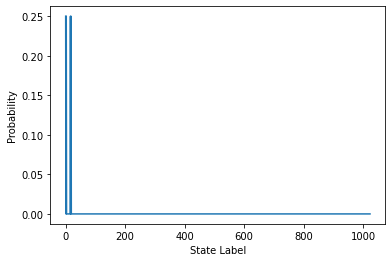

In [9]:
noisy_qpu_NISQ = NoisyQProc(hardware_model = hardware_model_NISQ, sim_method = "deterministic")

wf = wavefunction(binded_ansatz, noisy_qpu_NISQ, probs=True)
plt.xlabel("State Label")
plt.ylabel("Probability")
plt.plot(wf);
    

And if you wish you can have access to the states:

In [10]:
result = noisy_qpu_NISQ.submit(binded_ansatz.to_job())
for sample in result:
    print("State %s, probability %s, err %s"%(sample.state, sample.probability, sample.err))

State |0000000000>, probability 0.25000000000000083, err None
State |0000000010>, probability 0.25000000000000067, err None
State |0000010000>, probability 0.25000000000000067, err None
State |0000010010>, probability 0.2500000000000005, err None


### Exercise 2: Add gate noise

Besides adding idle noise, one can model imperfect gates. One way of doing so is to append to each noiseless gate a noisy channel that best models the imperfections of that gate (how to measure these imperfections is outside of the scope of this workshop)
$$X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} ; Y = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix} ; Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$$


Note : use 1j for i.

Modify the probability (from 0 to 1) to the impact.




In [11]:
from qat.hardware.default import DefaultGatesSpecification, HardwareModel
from qat.quops import QuantumChannelKraus


prob = 0.05
Xmat = np.array([[0, 1], [1, 0]])
Ymat = np.array([[0, -1j], [1j, 0]])
Zmat = np.array([[1, 0], [0, -1]])

# See Depolarizing channel definition from ie Nielsen&Chuang or Wikipedia
kraus_ops = [np.sqrt(1-prob)*np.identity(2),
             np.sqrt(prob/3)*Xmat, np.sqrt(prob/3)*Ymat, np.sqrt(prob/3)*Zmat]
noise = QuantumChannelKraus(kraus_ops)

print("These are the Pauli matrices:")
print(Xmat)
print(Ymat)
print(Zmat)

These are the Pauli matrices:
[[0 1]
 [1 0]]
[[ 0.+0.j -0.-1.j]
 [ 0.+1.j  0.+0.j]]
[[ 1  0]
 [ 0 -1]]


In [12]:
from qat.hardware.default import DefaultGatesSpecification, HardwareModel

gtimes = {"H": 2, "PH": 5, "RX": 5, "CNOT": 30 }
gnoise = {"H": lambda: noise,"PH": lambda _: noise,"RX": lambda _: noise}
inoise = [ParametricAmplitudeDamping(T_1=1e10), ParametricPureDephasing(T_phi=1e10)]

hardware_model_NISQ2 = DefaultHardwareModel(gate_times=gtimes, gate_noise=gnoise, idle_noise=inoise)

Use the defined noisy qpu  to compute the wave function.

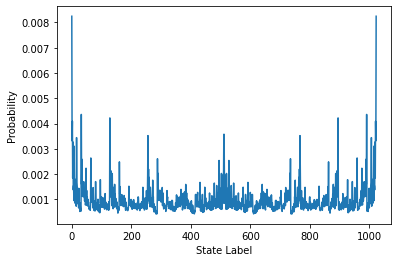

In [13]:
noisy_qpu_NISQ2 = NoisyQProc(hardware_model = hardware_model_NISQ2, sim_method = "deterministic")

ansatz = problem.qaoa_ansatz(1).circuit
binded_ansatz = ansatz.bind_variables({"\\gamma_{0}": np.pi/3,"\\beta_{0}": 5*np.pi/2 })

wf = wavefunction(binded_ansatz, noisy_qpu_NISQ2, probs=True)
plt.xlabel("State Label")
plt.ylabel("Probability")
plt.plot(wf);

Now your goal is:

 - to introduce dephasing noise after the H and CNOT gates, and bitflip noise after the RX gates.
 - to see how the wavefunction changes as we vary the noise strengths and gate duration

In [14]:
prob_bitflip = 0.0
kraus_ops_bitflip = [np.sqrt(1-prob_bitflip)*np.identity(2),np.sqrt(prob_bitflip)*Xmat]
noise_bitflip = QuantumChannelKraus(kraus_ops_bitflip)

prob_phaseflip = 0.0
kraus_ops_phaseflip = [np.sqrt(1-prob_phaseflip)*np.identity(2),np.sqrt(prob_phaseflip)*Zmat]
noise_phaseflip = QuantumChannelKraus(kraus_ops_phaseflip)

In [15]:
gtimes = {"H": 2, "PH": 5, "RX": 5, "CNOT": 30 }
gnoise = {"H": lambda: noise_phaseflip,"PH": lambda _: noise_phaseflip,"RX": lambda _: noise_bitflip}
inoise = [ParametricAmplitudeDamping(T_1=1e10), ParametricPureDephasing(T_phi=1e10)]

hardware_model_NISQ3 = DefaultHardwareModel(gate_times=gtimes, gate_noise=gnoise, idle_noise=inoise)

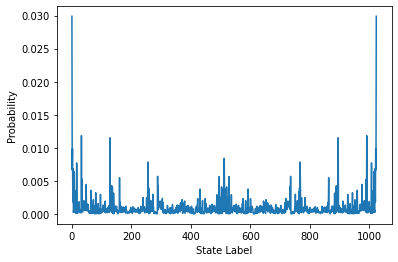

In [16]:
noisy_qpu_NISQ3 = NoisyQProc(hardware_model = hardware_model_NISQ3, sim_method = "deterministic")

ansatz = problem.qaoa_ansatz(1).circuit
binded_ansatz = ansatz.bind_variables({"\\gamma_{0}": np.pi/3,"\\beta_{0}": 5*np.pi/2 })

wf = wavefunction(binded_ansatz, noisy_qpu_NISQ3, probs=True)
plt.xlabel("State Label")
plt.ylabel("Probability")
plt.plot(wf);

Vary the different parameters to see the impact of those.

### Exercise 3: Include the outer optimisation loop and compare with the classical case

We will use a COBYLA optimiser and 2 layers for the ansatz. 

Final energy: -14.909572272283937
The optimization data:


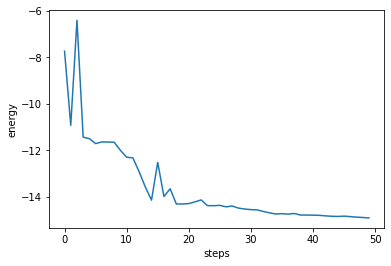

In [17]:
from qat.plugins import  ScipyMinimizePlugin
cobyla = ScipyMinimizePlugin(method="COBYLA", 
                             tol=1e-2, 
                             options={"maxiter": 50})
stack = cobyla | LinAlg()

result = stack.submit(problem.to_job(2))
print("Final energy:", result.value)
print("The optimization data:")
plt.plot(eval(result.meta_data['optimization_trace']))
plt.xlabel("steps")
plt.ylabel("energy")
plt.show()

Now the goal is to see how changing the noise and circuit depth will reduce the quality of the variational algorithm

Final energy: -12.84069611037854
The optimization data:


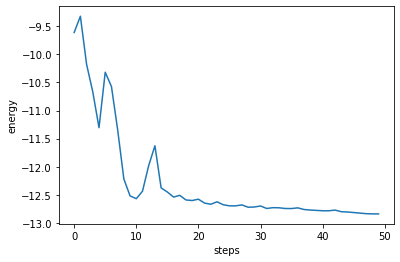

In [18]:
from qat.plugins import ObservableSplitter

hardware_model_NISQ4 = DefaultHardwareModel(
                    gate_times = {"H": 2, "PH": 5, "RX": 5, "CNOT": 30, "SWAP": 40
                                  },
                    idle_noise = [ParametricAmplitudeDamping(T_1=1000), ParametricPureDephasing(T_phi=1000)]
                )


job = problem.qaoa_ansatz(2)

noisy_qpu_NISQ = NoisyQProc(hardware_model = hardware_model_NISQ4, sim_method = "deterministic-vectorized")
#noisy_qpu_NISQ = NoisyQProc(hardware_model = hardware_model_NISQ4, sim_method = "stochastic", 
#                             backend_simulator=qat.linalg.LinAlg(),n_samples=100)


stack = cobyla | noisy_qpu_NISQ

result = stack.submit(job)
print("Final energy:", result.value)
print("The optimization data:")
plt.plot(eval(result.meta_data['optimization_trace']))
plt.xlabel("steps")
plt.ylabel("energy")
plt.show()